C:\Users\vanim\AppData\Local\Temp\ipykernel_11820\3981421392.py:12: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:/Users/vanim/Downloads/archive/data.csv", encoding='latin1')


Epoch 0 | D Loss: 1.3833 | G Loss: 0.7498
Epoch 200 | D Loss: 1.3021 | G Loss: 0.7882
Epoch 400 | D Loss: 1.2822 | G Loss: 0.8810
Epoch 600 | D Loss: 1.6354 | G Loss: 0.4995
Epoch 800 | D Loss: 1.3563 | G Loss: 0.7783
Epoch 1000 | D Loss: 1.3148 | G Loss: 0.7171
Epoch 1200 | D Loss: 1.2142 | G Loss: 0.9263
Epoch 1400 | D Loss: 1.4084 | G Loss: 0.7493
Epoch 1600 | D Loss: 1.3528 | G Loss: 0.7353
Epoch 1800 | D Loss: 1.3530 | G Loss: 0.7047


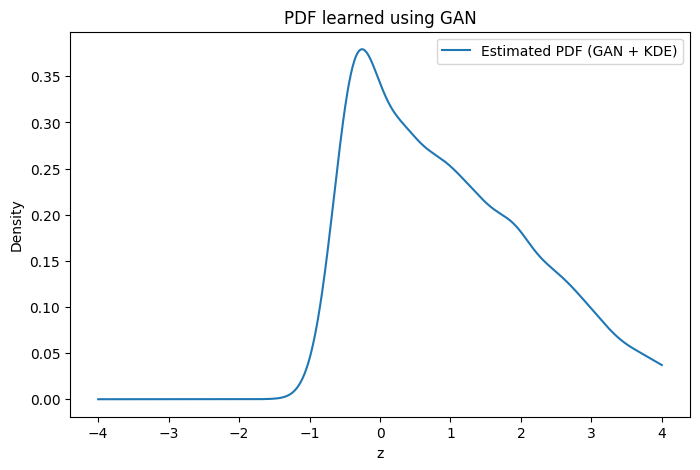

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# -----------------------------
# Step 1: Load Dataset
# -----------------------------
df = pd.read_csv("C:/Users/vanim/Downloads/archive/data.csv", encoding='latin1')
x = df['no2'].dropna().values

# -----------------------------
# Step 2: Transformation
# -----------------------------
r = 102303064
a_r = 0.5 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

z = x + a_r * np.sin(b_r * x)

# Normalize for stable GAN training
z = (z - np.mean(z)) / np.std(z)

z = torch.tensor(z, dtype=torch.float32).view(-1, 1)

# -----------------------------
# GAN Architecture
# -----------------------------

latent_dim = 5

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

G = Generator()
D = Discriminator()

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002)
optimizer_D = optim.Adam(D.parameters(), lr=0.0002)

# -----------------------------
# Training
# -----------------------------

epochs = 2000
batch_size = 128

for epoch in range(epochs):

    idx = np.random.randint(0, z.size(0), batch_size)
    real_samples = z[idx]

    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    # Train Discriminator
    noise = torch.randn(batch_size, latent_dim)
    fake_samples = G(noise)

    loss_real = criterion(D(real_samples), real_labels)
    loss_fake = criterion(D(fake_samples.detach()), fake_labels)

    loss_D = loss_real + loss_fake

    optimizer_D.zero_grad()
    loss_D.backward()
    optimizer_D.step()

    # Train Generator
    noise = torch.randn(batch_size, latent_dim)
    fake_samples = G(noise)
    loss_G = criterion(D(fake_samples), real_labels)

    optimizer_G.zero_grad()
    loss_G.backward()
    optimizer_G.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

# -----------------------------
# Step 3: PDF Estimation
# -----------------------------

G.eval()
noise = torch.randn(10000, latent_dim)
generated_samples = G(noise).detach().numpy()

# KDE estimation
kde = KernelDensity(kernel='gaussian', bandwidth=0.2)
kde.fit(generated_samples)

z_range = np.linspace(-4, 4, 1000).reshape(-1, 1)
log_density = kde.score_samples(z_range)
density = np.exp(log_density)

# Plot PDF
plt.figure(figsize=(8,5))
plt.plot(z_range, density, label="Estimated PDF (GAN + KDE)")
plt.title("PDF learned using GAN")
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
plt.show()


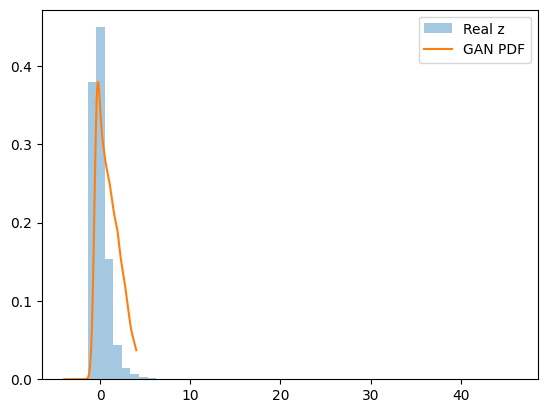

In [2]:
plt.hist(z.numpy(), bins=50, density=True, alpha=0.4, label="Real z")
plt.plot(z_range, density, label="GAN PDF")
plt.legend()
plt.show()
